<a href="https://colab.research.google.com/github/mldessu/projetsimu/blob/main/Matrice_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center; font-family: Arial, sans-serif; margin-top: 50px;">
<h1 style="font-size: 36px; font-weight: bold; color: #4CAF50;">Mini-projet 4 - Méthode de la matrice 2D.</h1>
<h2 style="font-size: 20px; font-weight: bold; color: #4CAF50;">PHS3903</h2>
<h2 style="font-size: 20px; margin-bottom: 20px;"> Marie-Lou Dessureault, </h2>
<h2 style="font-size: 16px; margin-bottom: 10px;">2211129, </h2>
<h2 style="font-size: 20px; margin-bottom: 20px;"> Tendano Yehama Bantia Luther, </h2>
<h2 style="font-size: 16px; margin-bottom: 10px;">2141649, </h2>
<h2 style="font-size: 20px; margin-bottom: 20px;"> Elliott Menu, </h2>
<h2 style="font-size: 16px; margin-bottom: 10px;">2147422, </h2>
<h2 style="font-size: 16px; margin-bottom: 10px;">19 Février 2024</h2>
<h2 style="font-size: 16px; margin-bottom: 10px;">Shawn Molesky, Maksim Skorobogatiy, Jérémie Villeneuve</h2>
</div>


## Travail préparatoire

Pour cette simulation, on considère que l'appartement est vu de haut et que les coordonnées $x$ et $y$ correspondent aux coordonnées au sol. Par conséquent, on pose que les quatres murs externes ont des conditions convectives. Celles-ci sont décrites tel que,
- pour le mur $y=0$:
$$
-k_{mur} \frac{-3T_{1,j}+4T_{2,j}-T_{3,j}}{2d} = -h(T_{1,j}-T_a)+O(d^2),
$$
- pour le mur $y=L_y$:
$$
-k_{mur} \frac{T_{N_y-2,j}-4T_{N_y-1,j}+3T_{N_y,j}}{2d} = h(T_{N_y,j}-T_a)+O(d^2),
$$
- pour le mur $x=0$:
$$
-k_{mur} \frac{-3T_{i,1}+4T_{i,2}-T_{i,3}}{2d} = -h(T_{i,1}-T_a)+O(d^2),
$$
- et pour le mur $x=L_x$:
$$
-k_{mur} \frac{T_{i,N_x-2}-4T_{i,N_x-1}+3T_{i,N_x}}{2d} = h(T_{i,N_x}-T_a)+O(d^2).
$$
Ici, $i$ correspond à la ligne ($i=1,2,...,N_y$), $j$ correspond à la colonne ($j=1,2,...,N_x$), $d$ est le pas ($\Delta x=\Delta y= d$), $h$ est le coefficient de transfert de chaleur et $T_a$ est la température ambiante extérieure. 

Pour considérer la continuité de flux de chaleur sur les parois internes des murs, on rajoute la condition suivante pour les noeuds situés directement sur les surfaces:
$$
-k_{sup}\frac{-3T_{N_m,j}+4T_{N_m+1,j}-T_{N_m+2,j}}{2d}=-k_{inf}\frac{T_{N_m-2,j}-4T_{N_m-1,j}+3T_{N_m,j}}{2d} + O(d^2),
$$
où $N_m$ est l'indice du noeud sur la surface interne, $k_{sup}$ est la conductivité thermique des noeuds ayant un indice supérieur à $N_m$ et $k_{inf}$ est la conductivité thermique des noeuds ayant un indice supérieur à $N_m$ ($k_{mur}$ ou $k_{air}$). L'équation ci-dessus correspond aux murs horizontaux (parallèles à l'axe des $x$), mais le même principe serait appliqué pour les murs verticaux (parallèles à l'axe des $y$) en inversant les indices.

<>:262: SyntaxWarning: invalid escape sequence '\c'
<>:262: SyntaxWarning: invalid escape sequence '\c'
C:\Users\menue\AppData\Local\Temp\ipykernel_22604\3013413852.py:262: SyntaxWarning: invalid escape sequence '\c'
  plt.title('k(x,y) [W/($m^2\cdot$K)]')


Pas de discrétisation dx=dy= 0.1 m
Pas de discrétisation dx=dy= 0.05 m
Pas de discrétisation dx=dy= 0.025 m


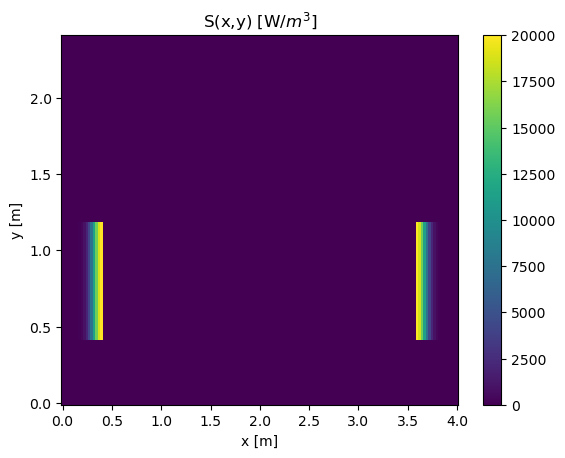

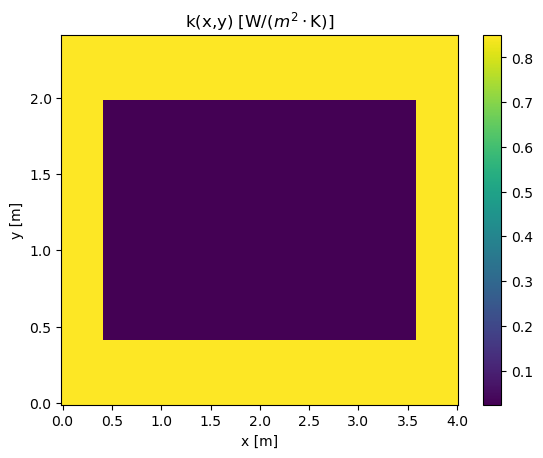

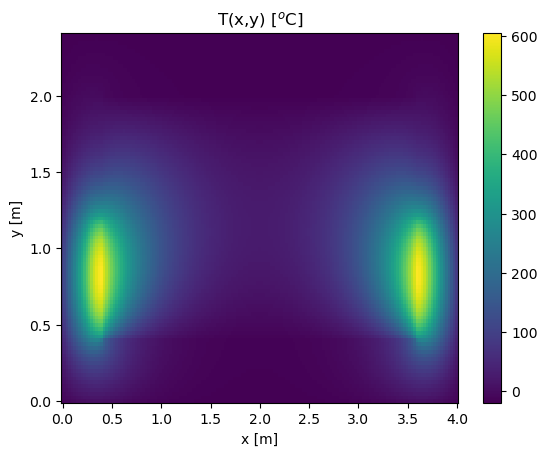

In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Distribution de la température dans un appartement d'un immeuble à plusieurs étages


# Équation de transfert de chaleur:
# k*(d^2 T(x,y)/dx^2 + d^2 T(x,y)/dy^2)+S=0


# Conditions aux limites:

# (1) Condition convective (de Robin) à x=0 et à x=Lx, y=0 et y=Ly (faces externes du mur):
# -k*dT(x=0,y)/dx=-h*(T-Ta)
# -k*dT(x=L,y)/dx=h*(T-Ta)
Ta = -20      # [oC]

# Dimensions d'appartement
Lx = 4        # [m]
Ly = 2.4      # [m]

# Paramètres d'un mur d'isolation thermique
Lm = 0.4      # [m] ; Épaisseur du mur en brique
km = 0.85     # [W/(m*K)] ; La conductivité thermique de la brique
h = 10        # [W/(m^2*K)] ; Coefficient de transfert thermique sur les surfaces extérieures du mur

# Paramètres de l'air qui remplit l'appartement
ka = 0.024    # La conductivité thermique à l'intérieur de l'appartement

delta = 0.1 * np.array([1, 1/2, 1/4], dtype=np.double) # Discrétisation en [m]
d_ar = np.zeros(delta.size,dtype=np.double)
tini_ar = np.zeros(delta.size,dtype=np.double)
tinv_ar = np.zeros(delta.size,dtype=np.double)
mem_ar = np.zeros(delta.size,dtype=np.double)
Tm_ar = np.zeros(delta.size,dtype=np.double)
Err_ar = np.zeros(delta.size-1,dtype=np.double)
d_Err_ar = np.zeros(delta.size-1,dtype=np.double)

def is_inside_structure(i, j):
    if 1 < i < Ny and 1 < j < Nx:
        # Espace intérieur sans les mur
        inner_i_min = 1 + Lm/d
        inner_i_max = Ny - Lm/d
        inner_j_min = 1 + Lm/d
        inner_j_max = Nx - Lm/d

        if (i == inner_i_min or i == inner_i_max) and (inner_j_min < j < inner_j_max):
            return False  # Surfaces verticales du mur interne
        if (j == inner_j_min or j == inner_j_max) and (inner_i_min < i < inner_i_max):
            return False  # Surfaces horizontales du mur interne

        return True  # Le point est à l'intérieur de la pièce ou dans le mur
    return False

ci = -1
for d in delta:
    ci = ci + 1
    print('Pas de discrétisation dx=dy=',d,'m')
    d_ar[ci] = d
    Nx = int(np.rint(Lx / d + 1)) # Nombre de nœuds le long de X
    Ny = int(np.rint(Ly / d + 1)) # Nombre de nœuds le long de Y

    tic=time.time_ns()

    # Initialisation de la source de chaleur, de la conductivité thermique et de la matrice
    S = np.zeros((Ny,Nx),dtype=np.double)
    k = np.zeros((Ny,Nx),dtype=np.double)

    for i in np.arange(1, Ny + 1, 1): # i=1,..,Ny - numérotation des nœuds sur un maillage physique
        y = (i - 1) * d
        for j in np.arange(1, Nx + 1, 1): # j=1,..,Nx - numérotation des nœuds sur un maillage physique
            x = (j - 1) * d

            # Source volumique de chaleur q[W/m^3] d'épaisseur dL.
            # La source est intégrée dans les parties intérieures du mur à x=Lm et à x=Lx-Lm et
            # il occupe les tiers du mur dans la direction verticale
            dL = 0.1
            q = 2.0e4   # W/m^3;
            if ((x <= Lm) and (y <= Ly / 3 + Lm) and (y > Lm)):
                # À l'intérieur de l'élément chauffant
                S[i - 1, j - 1] = q * np.exp(-((x - Lm) / dL) ** 2)

            elif ((x >= (Lx - Lm)) and (y <= Ly / 3 + Lm) and (y > Lm)):
                # À l'intérieur de l'élément chauffant
                S[i - 1, j - 1] = q * np.exp(-((Lx - Lm - x) / dL) ** 2)

            else:
                # À l'extérieur de l'élément chauffant
                S[i - 1, j - 1] = 0.0

            # L'espace de vie de l'appartement est délimité par
            # Les parois d'épaisseur Lm à tous les quatre côtés
            if ((x <= Lm) or (x >= (Lx - Lm)) or (y <= Lm) or (y >= (Ly - Lm))):
                # À l'intérieur du mur
                k[i - 1, j - 1] = km
            else:
                # À l'intérieur de l'appartement
                k[i - 1, j - 1] = ka

    M = np.zeros((Nx * Ny, Nx * Ny),dtype=np.double)
    b = np.zeros((Nx * Ny, 1),dtype=np.double)
    T = np.zeros((Nx * Ny, 1),dtype=np.double)
    Tr = np.zeros((Ny, Nx),dtype=np.double)

    for i in np.arange(1, Ny + 1, 1):
        for j in np.arange(1, Nx + 1, 1):
            # remplir la ligne pl de la matrice M
            pl = (i - 1) * Nx + j

            if is_inside_structure(i,j):
                # noeud qui est strictement à l'intérieur de la cellule de
                # simulation (sauf sur les surfaces intérieures des murs)
                pc = pl
                M[pl - 1, pc - 1] = -4      # contribution de noeud (i,j)
                pc = (i - 1) * Nx + (j - 1)
                M[pl - 1, pc - 1] = 1       # contribution de noeud (i,j-1)
                pc = (i - 1) * Nx + (j + 1)
                M[pl - 1, pc - 1] = 1       # contribution de noeud (i,j+1)
                pc = (i - 2) * Nx + j
                M[pl - 1, pc - 1] = 1       # contribution de noeud (i-1,j)
                pc = (i) * Nx + j
                M[pl - 1, pc - 1] = 1       # contribution de noeud (i+1,j)

                b[pl - 1] = -d ** 2 * S[i - 1, j - 1] / k[i - 1, j - 1]

            else:
                if (i == int(Lm / d + 1)): # sur le mur interne du bas y=0
                    pc = pl
                    M[pl - 1, pc - 1] = 3 * (ka + km)         # contribution de noeud (Lm/d+1,j) : surface mur
                    pc = (i) * Nx + j
                    M[pl - 1, pc - 1] = -4 * ka               # contribution de noeud (Lm/d+2,j) : air
                    pc = (i - 2) * Nx + j
                    M[pl - 1, pc - 1] = -4 * km               # contribution de noeud (Lm/d,j) : mur
                    pc = (i - 3) * Nx + j
                    M[pl - 1, pc - 1] = km                    # contribution de noeud (Lm/d-1,j) : mur
                    pc = (i + 1) * Nx + j
                    M[pl - 1, pc - 1] = ka                    # contribution de noeud (Lm/d+3,j) : air

                    b[pl - 1] = 0

                elif (i == int(Ny - Lm / d)): # sur le mur interne du haut y=Ly-Lm
                    pc = pl
                    M[pl - 1, pc - 1] = 3 * (ka + km)         # contribution de noeud (Ny-Lm/d-1,j) : surface mur
                    pc = (i) * Nx + j
                    M[pl - 1, pc - 1] = -4 * km               # contribution de noeud (Ny-Lm/d,j) : mur
                    pc = (i - 2) * Nx + j
                    M[pl - 1, pc - 1] = -4 * ka               # contribution de noeud (Ny-Lm/d-2,j) : air
                    pc = (i - 3) * Nx + j
                    M[pl - 1, pc - 1] = ka                    # contribution de noeud (Ny-Lm/d-3,j) : air
                    pc = (i + 1) * Nx + j
                    M[pl - 1, pc - 1] = km                    # contribution de noeud (Ny-Lm/d+1,j) : mur

                    b[pl - 1] = 0

                elif (j == int(Lm / d + 1)): # sur le mur interne gauche x=0
                    pc = pl
                    M[pl - 1, pc - 1] = 3 * (ka + km)         # contribution de noeud (i,Lm/d+1) : surface mur
                    pc = (i - 1) * Nx + (j - 1)
                    M[pl - 1, pc - 1] = -4 * km               # contribution de noeud (i,Lm/d) : mur
                    pc = (i - 1) * Nx + (j + 1)
                    M[pl - 1, pc - 1] = -4 * ka               # contribution de noeud (i,Lm/d+2) : air
                    pc = (i - 1) * Nx + (j + 2)
                    M[pl - 1, pc - 1] = ka                    # contribution de noeud (i,Lm/d+3) : air
                    pc = (i - 1) * Nx + (j - 2)
                    M[pl - 1, pc - 1] = km                    # contribution de noeud (i,Lm/d-1) : mur

                    b[pl - 1] = 0

                elif (j == int(Nx - Lm / d)): # sur le mur interne droit x=Lx-Lm
                    pc = pl
                    M[pl - 1, pc - 1] = 3 * (ka + km)         # contribution de noeud (i,Nx-Lm/d) : surface mur
                    pc = (i - 1) * Nx + (j - 1)
                    M[pl - 1, pc - 1] = -4 * ka               # contribution de noeud (i,Nx-Lm/d-1) : air
                    pc = (i - 1) * Nx + (j + 1)
                    M[pl - 1, pc - 1] = -4 * km               # contribution de noeud (i,Nx-Lm/d+1) : mur
                    pc = (i - 1) * Nx + (j + 2)
                    M[pl - 1, pc - 1] = km                    # contribution de noeud (i,Nx-Lm/d+2) : mur
                    pc = (i - 1) * Nx + (j - 2)
                    M[pl - 1, pc - 1] = ka                    # contribution de noeud (i,Nx-Lm/d-2) : air

                    b[pl - 1] = 0

                elif (i == 1):
                    # noeud à la surface externe du mur y=0
                    pc = pl
                    M[pl - 1, pc - 1] = 3 + 2 * d * h / k[i - 1, j - 1]     # contribution de noeud (1,j)
                    pc = (i) * Nx + j
                    M[pl - 1, pc - 1] = -4                                  # contribution de noeud (2,j)
                    pc = (i + 1) * Nx + j
                    M[pl - 1, pc - 1] = 1                                   # contribution de noeud (3,j)

                    b[pl - 1] = 2 * d * h * Ta / k[i - 1, j - 1]

                elif (i == Ny):
                    # noeud à la surface externe du mur y=Ny
                    pc = pl
                    M[pl - 1, pc - 1] = 3 + 2 * d * h / k[i - 1, j - 1]     # contribution de noeud (Ny,j)
                    pc = (i - 2) * Nx + j
                    M[pl - 1, pc - 1] = -4                                  # contribution de noeud (Ny-1,j)
                    pc = (i - 3) * Nx + j
                    M[pl - 1, pc - 1] = 1                                   # contribution de noeud (Ny-2,j)

                    b[pl - 1] = 2 * d * h * Ta / k[i - 1, j - 1]

                elif (j == 1):
                    # noeud à la surface externe du mur x=0
                    pc = pl
                    M[pl - 1, pc - 1] = 3 + 2 * d * h / k[i - 1, j - 1]     # contribution de noeud (i,1)
                    pc = (i - 1) * Nx + (j + 1)
                    M[pl - 1, pc - 1] = -4                                  # contribution de noeud (i,2)
                    pc = (i - 1) * Nx + (j + 2)
                    M[pl - 1, pc - 1] = 1                                   # contribution de noeud (i,3)

                    b[pl - 1] = 2 * d * h * Ta / k[i - 1, j - 1]

                elif (j == Nx):
                    # noeud à la surface externe du mur x=Nx
                    pc = pl
                    M[pl - 1, pc - 1] = 3 + 2 * d * h / k[i - 1, j - 1]     # contribution de noeud (i,Nx)
                    pc = (i - 1) * Nx + (j - 1)
                    M[pl - 1, pc - 1] = -4                                  # contribution de noeud (i,Nx-1)
                    pc = (i - 1) * Nx + (j - 2)
                    M[pl - 1, pc - 1] = 1                                   # contribution de noeud (i,Nx-2)

                    b[pl - 1] = 2 * d  * h * Ta / k[i - 1, j - 1]

                else:
                    print('Erreur dans la définition de la matrice de coefficients')



    toc = time.time_ns()
    tini_ar[ci] = (toc - tic) / 1.0e9 #temps en [s]

    tic = time.time_ns()
    T = np.linalg.solve(M,b)
    toc = time.time_ns()
    tinv_ar[ci] = (toc - tic) / 1.0e9 #temps en [s]

    mem_ar[ci] = 8 * (Nx * Ny) ** 2

    Tr = np.reshape(T,(Ny,Nx),order='C')

    Tm_ar[ci] = Tr[int(np.rint(Ly / d / 2 + 1)) - 1, int(np.rint(Lx / d / 2 + 1)) - 1] # température au milieu du domaine de calcul

plt.figure(1)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,S)
plt.colorbar(mappable=None, cax=None, ax=None)
plt.title('S(x,y) [W/$m^3$]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

plt.figure(2)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,k)
plt.colorbar(mappable=None, cax=None, ax=None)
plt.title('k(x,y) [W/($m^2\cdot$K)]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

plt.figure(3)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,Tr)
plt.colorbar(mappable=None, cax=None, ax=None)
plt.title('T(x,y) [$^o$C]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()


Q2: ...

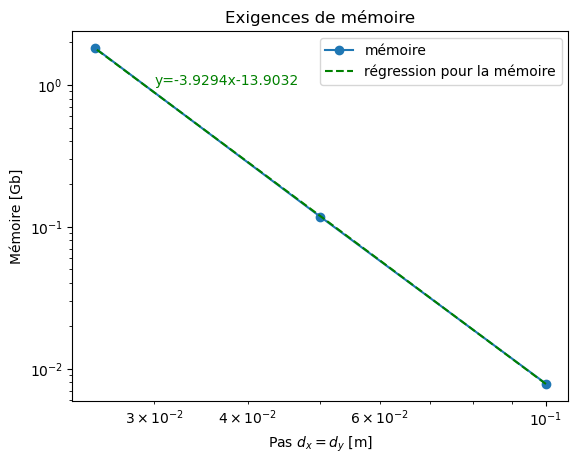

équation mémoire: Mem(δ) =(9.16e-07)*δ^-3.93


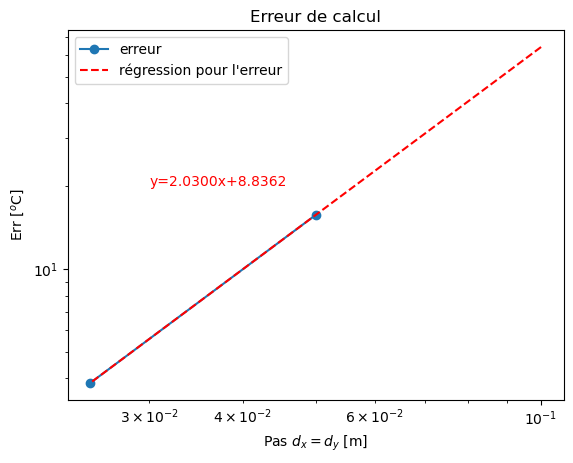

équation erreur: Err(δ) =(6.88e+03)*δ^2.03


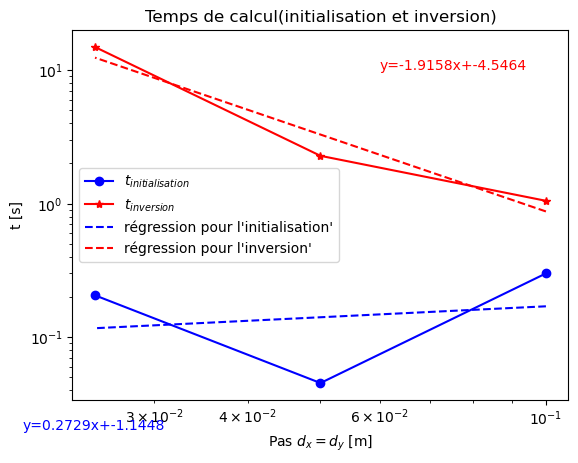

équation initialisation: Ini(δ) =(3.18e-01)*δ^0.27
équation inversion: Inv(δ) =(1.06e-02)*δ^-1.92


In [15]:
from scipy.stats import linregress

plt.figure(4)
plt.loglog(d_ar[::-1],mem_ar[::-1]/1024.0**3,'-o', label = "mémoire")
reg_mem= linregress(np.log(d_ar[::-1]),np.log(mem_ar[::-1]/1024.0**3))
m_mem= reg_mem.slope
b_mem= reg_mem.intercept
plt.loglog(d_ar,(d_ar**m_mem)*np.exp(b_mem), "--",label = "régression pour la mémoire", color= "green")
plt.text(3E-2,10E-1,f"y={m_mem:.4f}x{b_mem:.4f}", color="green")
plt.title('Exigences de mémoire')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Mémoire [Gb]')
plt.legend()
plt.show()
print(f"équation mémoire: Mem(δ) =({np.exp(b_mem):.2e})*δ^{m_mem:.2f}")

plt.figure(5)
Err_ar=abs(Tm_ar[:-1:]-Tm_ar[1::])
d_Err_ar=d_ar[1::] # Definiton d'erreur Err(delta)=|Tm(2*delta)-Tm(delta)|
plt.loglog(d_Err_ar[::-1],Err_ar[::-1],'-o', label = "erreur")
reg_err= linregress(np.log(d_Err_ar[::-1]),np.log(Err_ar[::-1]))
m_err= reg_err.slope
b_err= reg_err.intercept
plt.loglog(d_ar,(d_ar**m_err)*np.exp(b_err), "--",label = "régression pour l'erreur", color= "red")
plt.text(3E-2,2E1,f"y={m_err:.4f}x+{b_err:.4f}", color="red")
plt.title('Erreur de calcul')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Err [$^o$C]')
plt.legend()
plt.show()
print(f"équation erreur: Err(δ) =({np.exp(b_err):.2e})*δ^{m_err:.2f}")

plt.figure(6)
plt.loglog(d_ar[::-1],tini_ar[::-1],'-bo', label = '$t_{initialisation}$') 
plt.loglog(d_ar[::-1],tinv_ar[::-1],'-r*', label = '$t_{inversion}$')
reg_ini= linregress(np.log(d_ar[::-1]),np.log(tini_ar[::-1]))
reg_inv= linregress(np.log(d_ar[::-1]),np.log(tinv_ar[::-1]))
m_ini= reg_ini.slope
b_ini= reg_ini.intercept
m_inv= reg_inv.slope
b_inv= reg_inv.intercept
plt.loglog(d_ar,(d_ar**m_ini)*np.exp(b_ini), "--",label = "régression pour l'initialisation'", color= "b")
plt.text(2E-2,2E-2,f"y={m_ini:.4f}x+{b_ini:.4f}", color="b")
plt.loglog(d_ar,(d_ar**m_inv)*np.exp(b_inv), "--",label = "régression pour l'inversion'", color= "red")
plt.text(6E-2,1E1,f"y={m_inv:.4f}x+{b_inv:.4f}", color="red")
plt.title('Temps de calcul(initialisation et inversion)')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('t [s]')
plt.legend(loc = 'best')
plt.show()
print(f"équation initialisation: Ini(δ) =({np.exp(b_ini):.2e})*δ^{m_ini:.2f}")
print(f"équation inversion: Inv(δ) =({np.exp(b_inv):.2e})*δ^{m_inv:.2f}")


Q3: avec la régle déterminée à la question 2 pour le besoin en mémoire, $\delta_{2048}$ sera

In [19]:
d_2048 = (2048/np.exp(b_mem))**(1/m_mem)
t_ini = np.exp(b_ini)*d_2048**m_ini
t_inv = np.exp(b_inv)*d_2048**m_inv
err = np.exp(b_err)*d_2048**m_err
print(f"delta 2048= {d_2048:.5f} m")
print(f"temps d'initiation= {t_ini:.5f} s")
print(f"temps d'inversion= {t_inv:.5f} s")
print(f"Erreur= {err:.5f} °C")

delta 2048= 0.00418 m
temps d'initiation= 0.07137 s
temps d'inversion= 383.68175 s
Erreur= 0.10172 °C
